In [1]:
from collections import defaultdict
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import imageio
from IPython.display import Image

import mazelab
from mazelab.generators import random_maze
from mazelab.env import RandomizingMazeEnv

import gym
from gym.spaces import Box
from gym.spaces import Discrete

from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3 import A2C, DQN, PPO

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eric/Co

In [2]:
env = RandomizingMazeEnv(
    width=7,
    height=7,
    randomize_start=False,
    randomize_goal=False
)

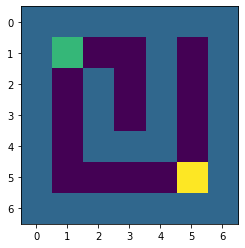

In [3]:
plt.imshow(env.reset())

In [4]:
env = RandomizingMazeEnv(
    width=8,
    height=8,
    randomize_start=True,
    randomize_goal=False
)

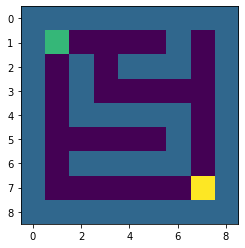

In [5]:
plt.imshow(env.reset())

In [6]:
env = gym.make('RandomMaze-8x8-FixedGoal-v0')

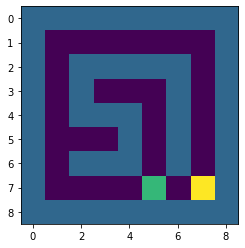

In [22]:
plt.imshow(env.reset())

# 2020-09-25

In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product
import h5py

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform

import gym
import mazelab
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm
import imageio
from IPython.display import Image

from stable_baselines3 import A2C
sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

from interp.common.wrappers import CustomRewardSSWrapper

In [2]:
########### Set Device ############
# device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device = 'cpu'
dtype = th.float32
th.set_default_dtype(dtype)
print(f"Using {device} device")

Using cpu device


In [3]:
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        w, h = env.observation_space.shape
        features = 2 * w * h
        self.net = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(features, 64, bias=True),
            nn.Tanh(),
            nn.Linear(64, 64, bias=True),
            nn.Tanh(),
            nn.Linear(64, 1, bias=False),
        ).to(device)
        self.device = device

    def forward(self, obs):
#         print(type(obs))
        x = th.tensor(obs).to(dtype).to(self.device)
#         print(x.shape, x.dtype)
#         x = x.reshape((1, 2, 11, 11))
#         print(x)
        return self.net(x)
    
    def tforward(self, ss):
        return self.net(ss)

In [4]:
envs = [
    "EmptyMaze-10x10-FixedGoal-v3",
    "EmptyMaze-10x10-CoinFlipGoal-v3",
]

In [5]:
env_id = envs[0]
print(env_id)
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

EmptyMaze-10x10-FixedGoal-v3


In [6]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

In [7]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-EmptyMaze-v2-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-EmptyMaze-v2-rollout.gif", width=110, height=110)

In [8]:
rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/{env_id}_ss-reward_model.pt", map_location='cpu'))

<All keys matched successfully>

In [9]:
N = 30

obs = env.reset()
next_obs = None
predicted_rewards = []
true_rewards = []
for i in range(N):
    action, _states = model.predict(obs, deterministic=False)
    next_obs, reward, done, info = env.step(action)
    reward_input = np.array((obs, next_obs)).astype(np.float32)
    predicted_rewards.append(float(rm(np.expand_dims(reward_input, axis=0)).item()))
    true_rewards.append(float(reward))
    if done:
        break
    else:
        obs = next_obs
print("Predicted: ", end='')
for i in range(len(predicted_rewards)):
    print("{:+.2f}".format(predicted_rewards[i]), end=' ')
print("")
print("True     : ", end='')
for i in range(len(predicted_rewards)):
    print("{:+.2f}".format(true_rewards[i]), end=' ')
print("")

Predicted: +0.01 +0.00 +0.00 -0.00 +0.01 +0.00 +0.00 +0.01 +0.00 -0.00 +0.01 +0.00 -0.00 -0.01 -0.00 -0.01 +0.01 +0.01 +0.01 +0.01 +0.00 +0.01 +0.01 +0.00 +0.01 +0.01 +0.00 +0.00 +0.01 +0.01 
True     : +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 +0.00 


In [19]:
senv = CustomRewardSSWrapper(model.env, rm)

In [20]:
obs = senv.reset()
obs

array([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]], dtype=uint8)

In [27]:
o, r, _, _ = senv.step([3])
print(o)
print(r)

[[[1 1 1 1 1 1 1 1 1 1 1]
  [1 0 0 0 0 0 0 0 0 0 1]
  [1 0 0 0 0 0 0 0 0 0 1]
  [1 0 0 0 0 2 0 0 0 0 1]
  [1 0 0 0 0 0 0 0 0 0 1]
  [1 0 0 0 0 0 0 0 0 0 1]
  [1 0 0 0 0 0 0 0 0 0 1]
  [1 0 0 0 0 0 0 0 0 0 1]
  [1 0 0 0 0 0 0 0 0 0 1]
  [1 0 0 0 0 0 0 0 0 3 1]
  [1 1 1 1 1 1 1 1 1 1 1]]]
[tensor([[1.0043]], grad_fn=<MmBackward>)]


In [44]:
obs = env.reset()
next_obs = None
obs

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [57]:
next_obs, reward, done, info = env.step(3)
reward_input = np.array((obs, next_obs)).astype(np.float32)
print(float(rm(np.expand_dims(reward_input, axis=0)).item()))
obs = next_obs

<class 'numpy.ndarray'>
torch.Size([1, 2, 11, 11]) torch.float32
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 2., 3., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

         [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0.

In [58]:
obs = model.env.reset()
next_obs = None
obs

array([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]], dtype=uint8)

In [71]:
next_obs, reward, done, info = model.env.step([3])
reward_input = np.array((obs.reshape((11, 11)), next_obs.reshape((11, 11)))).astype(np.float32)
print(float(rm(np.expand_dims(reward_input, axis=0)).item()))
obs = next_obs

<class 'numpy.ndarray'>
torch.Size([1, 2, 11, 11]) torch.float32
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 2., 3., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

         [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0.

In [10]:
from stable_baselines3.common.vec_env import DummyVecEnv

In [74]:
e = gym.make('EmptyMaze-10x10-FixedGoal-v3')

In [75]:
ve = DummyVecEnv([lambda: e])

In [77]:
obs = ve.reset()
obs.shape

(1, 11, 11)

In [79]:
obs = ve.reset()
next_obs = None
obs

array([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]], dtype=uint8)

In [92]:
next_obs, reward, done, info = ve.step([3])
reward_input = np.array((obs, next_obs)).astype(np.float32)
print(float(rm(np.expand_dims(reward_input, axis=0)).item()))
obs = next_obs

<class 'numpy.ndarray'>
torch.Size([1, 2, 1, 11, 11]) torch.float32
tensor([[[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
           [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
           [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
           [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
           [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
           [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
           [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
           [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
           [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
           [1., 0., 0., 0., 0., 0., 0., 0., 2., 3., 1.],
           [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


         [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
           [1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.],
           [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
           [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
           [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
           [1., 

In [98]:
info[0]['terminal_observation']

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [99]:
done

array([ True])

In [17]:
env = gym.make('EmptyMaze-10x10-TwoGoals-v3')
env = DummyVecEnv([lambda: env])

In [18]:
rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/EmptyMaze-10x10-CoinFlipGoal-v3_ss-reward_model.pt", map_location='cpu'))


<All keys matched successfully>

In [19]:
env = CustomRewardSSWrapper(env, rm)

In [20]:
obs = env.reset()
obs

array([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]], dtype=uint8)

In [29]:
obs, reward, done, info = env.step([3])
print(obs)
print(reward)

[[[1 1 1 1 1 1 1 1 1 1 1]
  [1 3 0 0 0 0 0 0 0 0 1]
  [1 0 0 0 0 0 0 0 0 0 1]
  [1 0 0 0 0 2 0 0 0 0 1]
  [1 0 0 0 0 0 0 0 0 0 1]
  [1 0 0 0 0 0 0 0 0 0 1]
  [1 0 0 0 0 0 0 0 0 0 1]
  [1 0 0 0 0 0 0 0 0 0 1]
  [1 0 0 0 0 0 0 0 0 0 1]
  [1 0 0 0 0 0 0 0 0 3 1]
  [1 1 1 1 1 1 1 1 1 1 1]]]
[tensor([[-0.0313]], grad_fn=<MmBackward>)]


In [23]:
obs = senv.reset()
for i in range(200):
    action, _states = model.predict(obs, deterministic=False)
    next_obs, reward, done, info = senv.step(action)
    print(reward)
    if done:
        break

<class 'numpy.ndarray'>
torch.Size([1, 2, 11, 11]) torch.float32
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

         [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0.

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

         [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0.,